# Robust Varibad Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cross_entropy_sampler as cem
import general_utils as utils
import analysis

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

C:\Users\idogr\AppData\Local\Temp\ipykernel_28096\867683384.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Configuration

In [2]:
ENV_NAME = 'HumanoidBody-v0'
TITLE = ENV_NAME[:-3]
ENV_SHORT = 'humb'
TASKS = ('mass', 'damping', 'head_size')
TASK_DIM = len(TASKS)
METHODS = ('varibad', 'cembad', 'cvrbad')
NM_MAP = dict(varibad='VariBAD', cvrbad='CVaR-ML', cembad='RoML')
SEEDS = list(range(30))
ALPHA = 0.05

### The CEM

In [3]:
TRANSFORMATION = lambda x: 2 ** (2*(x-0.5))
YLIM = (0, 2)
SMOOTH = 20
CEM_SEED = 0

In [4]:
# ce, c1, c2, axs1, axs2 = analysis.cem_analysis(
#     ENV_NAME, TASK_DIM, TRANSFORMATION, YLIM, SMOOTH, title=TITLE, tasks=TASKS, seed=CEM_SEED)
# plt.sca(axs1[0])
# plt.savefig(f'outputs/{ENV_SHORT}_sample_dist.png', bbox_inches='tight', dpi=300)
# plt.sca(axs2[0])
# plt.savefig(f'outputs/{ENV_SHORT}_cem.png', bbox_inches='tight', dpi=300)

## Test results

In [5]:
%%time
rr, rra, rrm, rrc, rr0, rra0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, lambda nm: 'best_mean' if nm=='varibad' else 'best_cvar', nm_map=NM_MAP)
rr

Test tasks: 1008
CPU times: total: 1min 15s
Wall time: 1min 25s


,ep,ret,task0,task1,task2,method,seed
0,0,1711.825684,0.717358,0.745208,1.406804,VariBAD,0
1,1,1723.233887,0.717358,0.745208,1.406804,VariBAD,0
2,0,1668.702271,0.524315,1.317300,1.474428,VariBAD,0
3,1,1710.005615,0.524315,1.317300,1.474428,VariBAD,0
4,0,1691.562378,0.814529,0.796273,1.711320,VariBAD,0
...,...,...,...,...,...,...,...
181435,1,593.933472,0.507586,0.514589,1.068804,CVaR-ML,29
181436,0,633.028015,0.968891,0.760111,0.854193,CVaR-ML,29
181437,1,419.942047,0.968891,0.760111,0.854193,CVaR-ML,29
181438,0,631.668884,0.769847,1.467487,0.531773,CVaR-ML,29


Test returns vs. task - over all seeds aggregated:
CPU times: total: 5.11 s
Wall time: 5.79 s


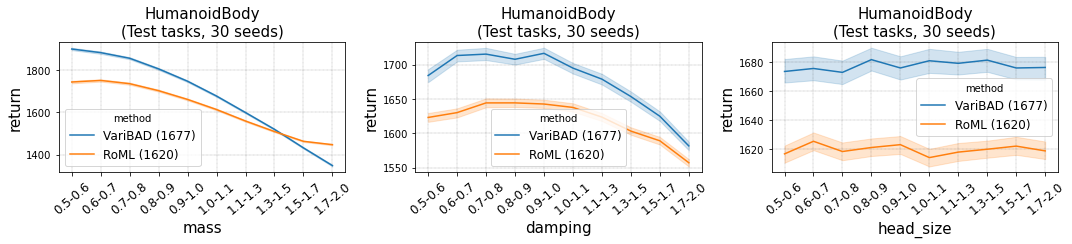

In [6]:
%%time
axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_x_ndigits=1)
plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

In [7]:
# axs = analysis.summarize_test(rra0, rr0, ALPHA)

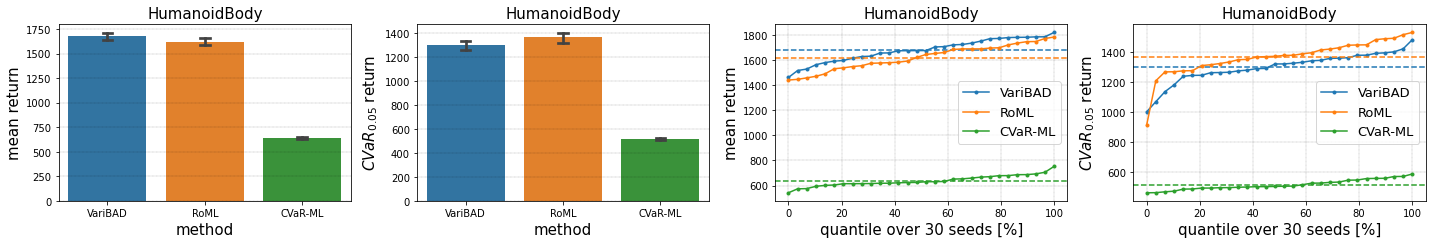

In [8]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE, barplot=True)

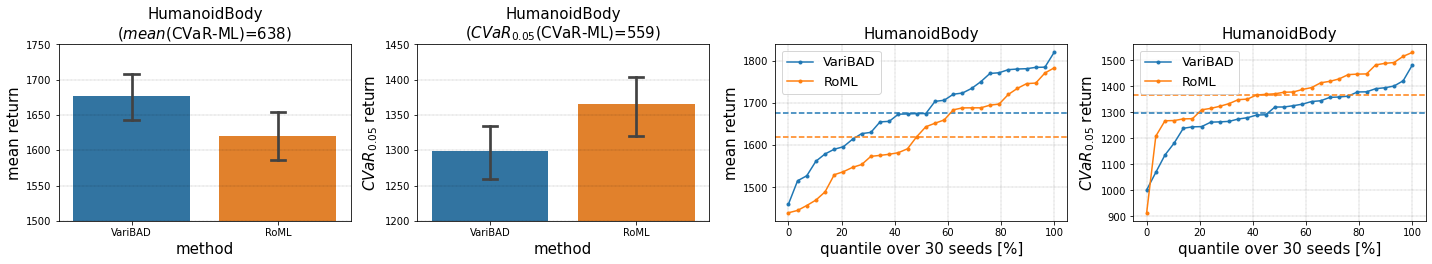

In [9]:
axs = analysis.summarize_test_over_seeds(rrm[rrm.method!='CVaR-ML'], rrc[rrc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_title(f'{TITLE}\n($mean$(CVaR-ML)={rrm.ret[rrm.method=="CVaR-ML"].mean():.0f})', fontsize=15)
axs[0].set_ylim((1500, 1750))
axs[1].set_title(f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={analysis.get_cvar_fun(ALPHA)(rrm.ret[rrm.method=="CVaR-ML"]):.0f})', fontsize=15)
axs[1].set_ylim((1200, 1450))
plt.savefig(f'outputs/{ENV_SHORT}_summary.png', bbox_inches='tight', dpi=300)

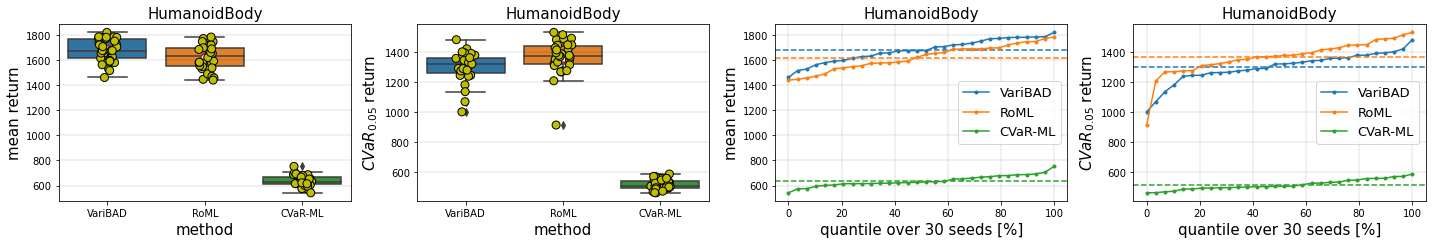

In [10]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE)

### Final models test (not best over validation)

In [11]:
%%time
bb, bba, bbm, bbc, bb0, bba0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'final', nm_map=NM_MAP)

Test tasks: 1008
CPU times: total: 1min 15s
Wall time: 1min 32s


Test returns vs. task - over all seeds aggregated:


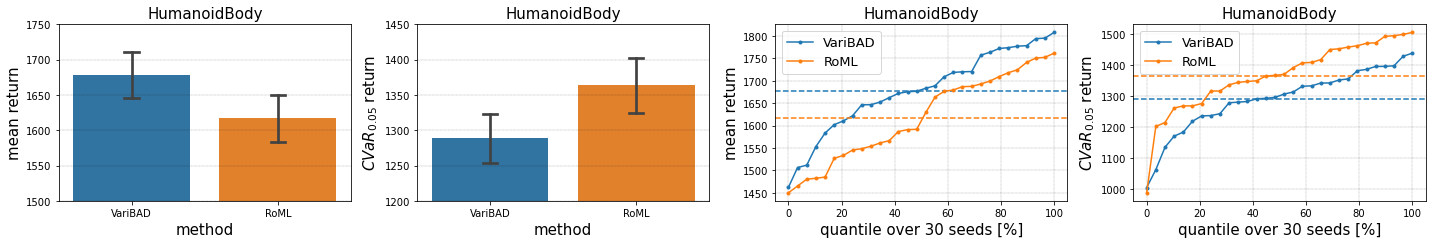

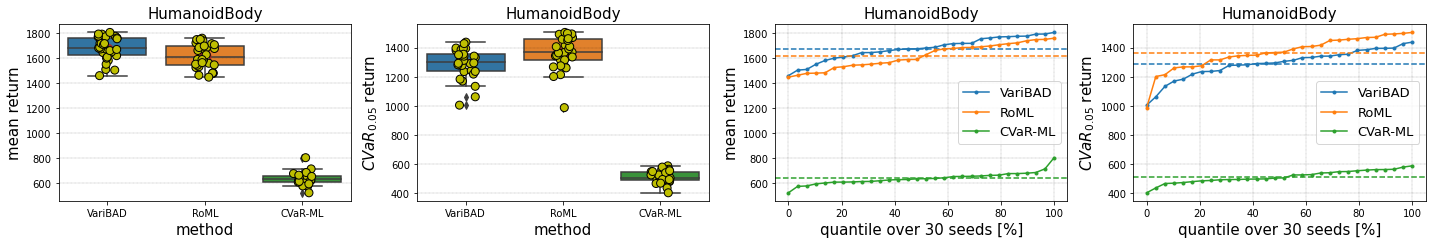

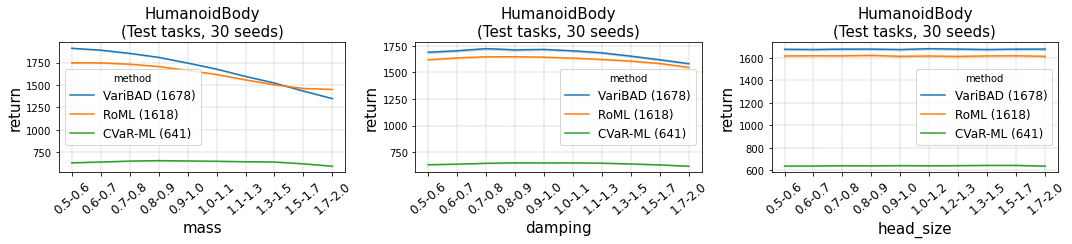

In [12]:
axs = analysis.summarize_test_over_seeds(bbm[bbm.method!='CVaR-ML'], bbc[bbc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_ylim((1500, 1750))
axs[1].set_ylim((1200, 1450))

axs = analysis.summarize_test_over_seeds(bbm, bbc, ALPHA, TITLE)
axs2 = analysis.show_test_vs_tasks(bba, bba0, TITLE, TASKS)

$mean$(CVaR-ML)=641
$CVaR_{0.05}$(CVaR-ML)=514


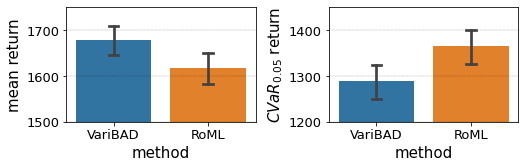

In [13]:
axs = utils.Axes(2, 2, (3.7,2.5), fontsize=15)
a = 0

sns.barplot(data=bbm[bbm.method!='CVaR-ML'], x='method', y='ret', ci=95, capsize=0.1, ax=axs[a])
axs[a].set_ylim((1500, 1750))
axs[a].tick_params(axis='both', which='major', labelsize=13)
axs.labs(a, 'method', f'mean return', '')  # f'{TITLE}\n($mean$(CVaR-ML)={bbm.ret[bbm.method=="CVaR-ML"].mean():.0f})')
print(f'$mean$(CVaR-ML)={bbm.ret[bbm.method=="CVaR-ML"].mean():.0f}')
a += 1

sns.barplot(data=bbc[bbc.method!='CVaR-ML'], x='method', y='ret', ci=95, capsize=0.1, ax=axs[a])
axs[a].set_ylim((1200, 1450))
axs[a].tick_params(axis='both', which='major', labelsize=13)
axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return', '')  # f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={bbc.ret[bbc.method=="CVaR-ML"].mean():.0f})')
print(f'$CVaR_{{{ALPHA}}}$(CVaR-ML)={bbc.ret[bbc.method=="CVaR-ML"].mean():.0f}')
a += 1

plt.tight_layout()
plt.savefig(f'outputs/{ENV_SHORT}_f_summary.png', bbox_inches='tight', dpi=300)

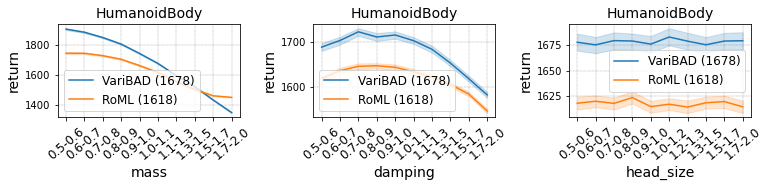

In [14]:
# axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_x_ndigits=1)

task_dim = analysis.get_task_dim(bba)
axs = utils.Axes(task_dim, task_dim, (3.6,2.7), fontsize=14)
a = 0
for i in range(task_dim):
    utils.compare_quantiles(bba[bba.method!='CVaR-ML'], f'task{i:d}', 'ret', 'method',
                            xbins=11, lab_rotation=40, axs=axs, a0=a, ci=95)
    axs.labs(a, TASKS[i], 'return', TITLE)
    axs[a].legend(fontsize=12)
    a += 1

plt.tight_layout()
plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

## Validation results

In [15]:
%%time
dd, dda, ddm, ddc, dd0, dda0, task_dim = analysis.load_train_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, nm_map=NM_MAP)
dd

humb_varibad_0__17_01_19_20_20
humb_varibad_1__17_01_19_20_25
humb_varibad_2__17_01_19_20_32
humb_varibad_3__17_01_19_20_36
humb_varibad_4__17_01_19_20_54
humb_varibad_5__17_01_19_21_00
humb_varibad_6__17_01_19_21_05
humb_varibad_7__17_01_19_21_00
humb_varibad_8__17_01_19_21_02
humb_varibad_9__17_01_19_21_06
humb_varibad_10__17_01_19_21_06
humb_varibad_11__17_01_19_21_05
humb_varibad_12__17_01_19_21_03
humb_varibad_13__17_01_19_21_09
humb_varibad_14__17_01_19_21_05
humb_varibad_15__17_01_19_21_08
humb_varibad_16__17_01_19_21_07
humb_varibad_17__17_01_19_21_08
humb_varibad_18__17_01_19_21_09
humb_varibad_19__17_01_19_21_11
humb_varibad_20__17_01_19_21_14
humb_varibad_21__17_01_19_21_15
humb_varibad_22__17_01_19_21_15
humb_varibad_23__17_01_19_21_17
humb_varibad_24__17_01_19_21_17
humb_varibad_25__17_01_19_21_24
humb_varibad_26__17_01_19_21_28
humb_varibad_27__17_01_19_21_41
humb_varibad_28__17_01_19_21_27
humb_varibad_29__17_01_19_21_43
humb_cembad_0__17_01_19_25_09
humb_cembad_1__17_01

,iter,task_id,ep,ret,task0,task1,task2,method,seed
0,-1,0,0,-20.670996,0.662402,0.571220,0.915925,VariBAD,0
1,-1,0,1,65.518875,0.662402,0.571220,0.915925,VariBAD,0
2,-1,1,0,64.575470,1.008133,0.629844,0.979349,VariBAD,0
3,-1,1,1,2.237382,1.008133,0.629844,0.979349,VariBAD,0
4,-1,2,0,5.312838,1.628311,1.188480,0.836204,VariBAD,0
...,...,...,...,...,...,...,...,...,...
1082875,4674,29,1,757.327820,1.819838,1.746387,0.522486,CVaR-ML,29
1082876,4674,30,0,762.518311,0.718412,1.200335,0.719030,CVaR-ML,29
1082877,4674,30,1,693.889404,0.718412,1.200335,0.719030,CVaR-ML,29
1082878,4674,31,0,566.889099,0.577331,0.551408,1.210098,CVaR-ML,29


In [16]:
# axs = analysis.show_task_distribution(dda0, rra0, TASKS)

In [17]:
# %%time
# axs = analysis.show_validation_vs_tasks(dda, TASKS)

In [18]:
# %%time
# axs = analysis.show_validation_results(dda0, ALPHA)

CPU times: total: 22.3 s
Wall time: 27.8 s


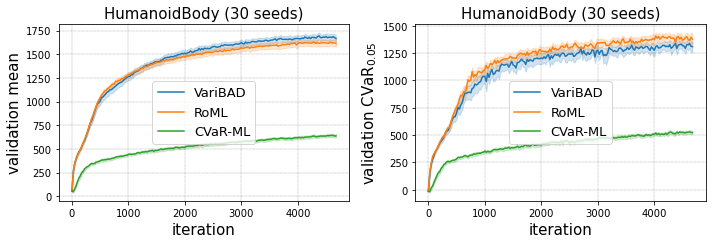

In [19]:
%%time
axs = analysis.show_validation_results_over_seeds(ddm, ddc, ALPHA, TITLE, ci=95, axsize=(5,3.5))
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
plt.savefig(f'outputs/{ENV_SHORT}_valid.png', bbox_inches='tight', dpi=300)